# Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix,mean_squared_error
import tensorflow as tf
import random as rn
import os
from tensorflow.keras import optimizers,backend as K
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation,BatchNormalization, CuDNNLSTM
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

# Function Definition

In [13]:
def cross_val(df,TIME_STEPS,BATCH_SIZE,n_fold,input_dropout,hidden_dropout,l2_regularizer,lstm_units_1,lstm_units_2,hidden_units_1,hidden_units_2,optimizer,epochs):
  '''
  TIME_STEPS: how many time steps before which used as predictor
  BATCH_SIZE: how long is a "season" period
  '''
  tscv = TimeSeriesSplit(n_splits=n_fold)
  mape_list=[]
  adj_mape_list=[]
  acc_list = []
  scaler=MinMaxScaler(feature_range=(0,1))
  for train_index, val_index in tscv.split(df):
    print("#Train Samples: ", len(train_index), "#Val Samples: ", len(val_index))
    df_train_raw,df_val_raw=df.loc[train_index,:],df.loc[val_index,:]

    #Rescaling
    df_train_scaled=scaler.fit_transform(df_train_raw)
    df_val_scaled=scaler.transform(df_val_raw)

    #Reformatting Data
    x_t, y_t = utils.build_timeseries(df_train_scaled, 3,TIME_STEPS)
    x_t = utils.trim_dataset(x_t, BATCH_SIZE)
    y_t = utils.trim_dataset(y_t, BATCH_SIZE)
    x_val, y_val = utils.build_timeseries(df_val_scaled, 3,TIME_STEPS)
    x_val = utils.trim_dataset(x_val, BATCH_SIZE)
    y_val = utils.trim_dataset(y_val, BATCH_SIZE)

    #Model Build
    model=Sequential()
    model.add(Input(batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2])))
    model.add(Dropout(input_dropout))
    model.add(CuDNNLSTM(units = lstm_units_1, return_sequences=True, kernel_initializer='random_uniform'))
    model.add(Dropout(hidden_dropout))
    model.add(CuDNNLSTM(units = lstm_units_2))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(hidden_units_1,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
    model.add(Activation('relu'))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(hidden_units_2,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
    model.add(Activation('relu'))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=['mape']) 

    history=model.fit(x_t, y_t,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    epochs=epochs,
                    verbose=False,
                    validation_data=(utils.trim_dataset(x_val, BATCH_SIZE),utils.trim_dataset(y_val, BATCH_SIZE)))

    y_pred = model.predict(utils.trim_dataset(x_val, BATCH_SIZE), batch_size=BATCH_SIZE)
    y_pred = y_pred.flatten()
    # convert the predicted value to range of real data
    y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_pred)
    y_val_t_org = (y_val * scaler.data_range_[3]) + scaler.data_min_[3]

    MAPE=utils.mape(y_val_t_org, y_pred_org)
    mape_list.append(MAPE)
    print('Val MAPE: ',MAPE)

    adj_MAPE=utils.adjusted_mape(y_val_t_org, y_pred_org)
    adj_mape_list.append(adj_MAPE)
    print('Val Adjusted MAPE: ',adj_MAPE)

    window=7

    y_pred_confusion=y_pred_org.tolist()
    y_pred_after_confusion=y_pred_confusion[window:]
    y_pred_before_confusion=y_pred_confusion[:-window]
    is_bullish_pred=(pd.Series(y_pred_after_confusion)-pd.Series(y_pred_before_confusion)).apply(lambda x: 1 if x>0 else 0)

    y_val_confusion=y_val_t_org.tolist()
    y_val_after_confusion=y_val_confusion[window:]
    y_val_before_confusion=y_val_confusion[:-window]
    is_bullish_val=(pd.Series(y_val_after_confusion)-pd.Series(y_val_before_confusion)).apply(lambda x: 1 if x>0 else 0)

    confusion=confusion_matrix(is_bullish_pred,is_bullish_val)
    acc=(confusion[0][0]+confusion[1][1])/(confusion[0][0]+confusion[0][1]+confusion[1][0]+confusion[1][1])
    acc_list.append(acc)

    print('Val Accuracy: ',acc)

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    print('')
    print('')

    #Plot Prediction Result
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_val_t_org)
    plt.title('Prediction vs Real Stock Price')
    plt.ylabel('Price ($)')
    plt.xlabel('Timesteps')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    plt.show()

    #Plot Prediction Result - Bahasa Indonesia
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_val_t_org)
    plt.title('Perbandingan Hasil Prediksi dengan Harga Saham Sebenarnya')
    plt.ylabel('Harga ($)')
    plt.xlabel('Waktu')
    plt.legend(['Prediksi', 'Sebenarnya'], loc='upper left')
    plt.show()

  print('10-Fold Accuracy Test Avg Score: {}, Std Score: {}'.format(np.mean(acc_list),np.std(acc_list)))
  print('10-Fold MAPE Test Avg Score: {}, Std Score: {}'.format(np.mean(mape_list),np.std(mape_list)))
  print('10-Fold Adjusted MAPE Test Avg Score: {}, Std Score: {}'.format(np.mean(adj_mape_list),np.std(adj_mape_list)))
  print('Epochs: {}'.format(epochs))
  print('LSTM Nodes 1: {}'.format(lstm_units_1))
  print('LSTM Nodes 2: {}'.format(lstm_units_2))
  print('Input Dropout Rate: {}'.format(input_dropout))
  print('Hidden Dropout Rate: {}'.format(hidden_dropout))
  print('Optimizer: {}'.format(optimizer))
  print('')

# Import Data

In [3]:
df = pd.read_csv('C:/Users/Louis Owen/Desktop/ICoDSA 2020/SENN/Dataset/Final/df_yfinance_BA_prepared.csv')
df=df.drop('Unnamed: 0',1)
df=df[['Open','High','Low','Close','Volume','SMA_indicator','close_diff_Upper_Bollinger','close_diff_Lower_Bollinger','Bollinger_indicator','true_range','date','weekday','time','close_before_1','close_before_2','close_before_3','close_before_4','close_before_5','close_before_6','close_before_7','close_before_8','close_before_9']]
df=df[~(pd.isnull(df.close_before_9))]
df=df.reset_index(drop=True)

In [4]:
df

,Open,High,Low,Close,Volume,SMA_indicator,close_diff_Upper_Bollinger,close_diff_Lower_Bollinger,Bollinger_indicator,true_range,...,time,close_before_1,close_before_2,close_before_3,close_before_4,close_before_5,close_before_6,close_before_7,close_before_8,close_before_9
0,312.024994,316.649994,311.380005,314.100006,734290,0,-13.328803,4.171039,3.0,5.269989,...,3,311.519989,312.899994,323.839996,320.820007,321.760010,323.340790,319.547791,320.520294,318.440002
1,314.140015,315.029999,310.989990,312.089996,436157,0,-15.192713,3.212910,3.0,4.040009,...,4,314.100006,311.519989,312.899994,323.839996,320.820007,321.760010,323.340790,319.547791,320.520294
2,311.989990,312.934998,310.341614,312.420013,415935,0,-14.551484,4.175030,3.0,2.593384,...,5,312.089996,314.100006,311.519989,312.899994,323.839996,320.820007,321.760010,323.340790,319.547791
3,312.450012,312.921997,309.665009,310.970001,535930,0,-15.819021,3.563810,3.0,3.256989,...,6,312.420013,312.089996,314.100006,311.519989,312.899994,323.839996,320.820007,321.760010,323.340790
4,310.890015,312.262207,310.130005,310.809998,757015,0,-15.737691,4.060702,3.0,2.132202,...,7,310.970001,312.420013,312.089996,314.100006,311.519989,312.899994,323.839996,320.820007,321.760010
5,316.404999,321.369995,316.079987,321.204498,823438,0,-5.572683,14.077229,2.0,10.559998,...,1,310.809998,310.970001,312.420013,312.089996,314.100006,311.519989,312.899994,323.839996,320.820007
6,321.335693,323.119995,320.929993,322.279999,587208,0,-4.863749,14.853323,2.0,2.190002,...,2,321.204498,310.809998,310.970001,312.420013,312.089996,314.100006,311.519989,312.899994,323.839996
7,321.929993,325.890015,321.380005,325.260010,482465,0,-2.793842,17.805227,2.0,4.510010,...,3,322.279999,321.204498,310.809998,310.970001,312.420013,312.089996,314.100006,311.519989,312.899994
8,325.459991,327.811310,324.768707,327.704987,458491,0,-1.640438,20.436147,2.0,3.042603,...,4,325.260010,322.279999,321.204498,310.809998,310.970001,312.420013,312.089996,314.100006,311.519989
9,327.839996,328.410004,325.989990,326.910004,426502,0,-3.280385,19.580562,2.0,2.420013,...,5,327.704987,325.260010,322.279999,321.204498,310.809998,310.970001,312.420013,312.089996,314.100006


## Hyperparameter Tuning

#Train Samples:  161 #Val Samples:  158
Val MAPE:  2.8518244896199674
Val Adjusted MAPE:  2.2397585160364146
Val Accuracy:  0.6713286713286714


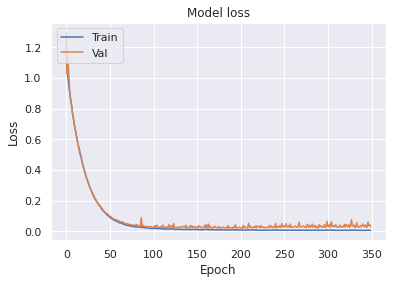

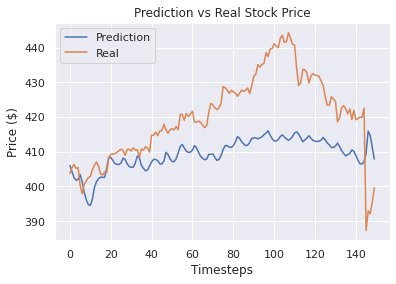

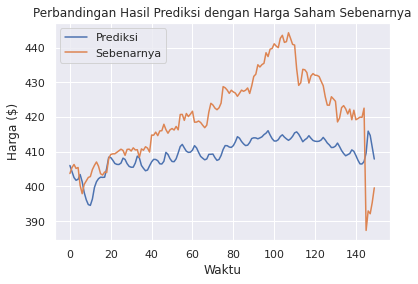

#Train Samples:  319 #Val Samples:  158
Val MAPE:  2.2345713785091816
Val Adjusted MAPE:  1.6782433846171139
Val Accuracy:  0.6993006993006993


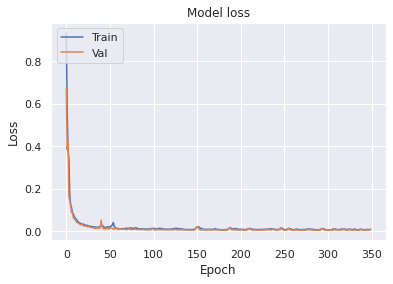

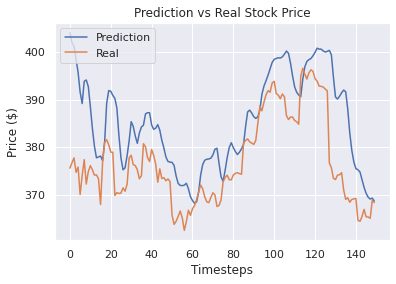

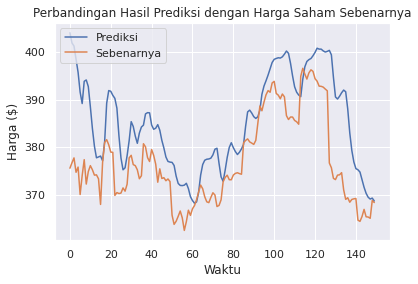

#Train Samples:  477 #Val Samples:  158
Val MAPE:  1.3379792265608499
Val Adjusted MAPE:  1.0179343911989154
Val Accuracy:  0.6713286713286714


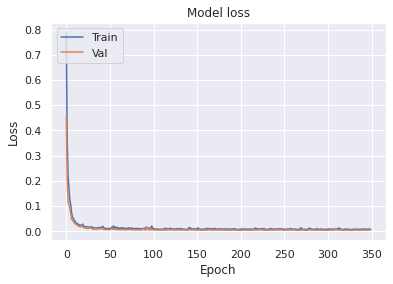

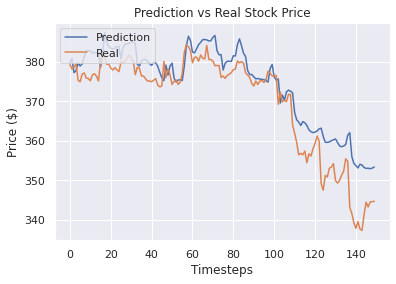

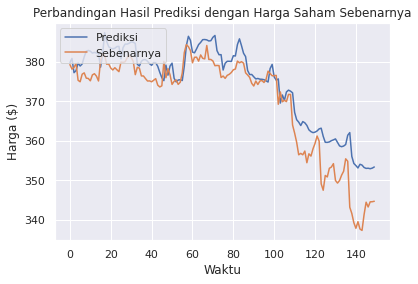

#Train Samples:  635 #Val Samples:  158
Val MAPE:  0.824399971145952
Val Adjusted MAPE:  0.5927520604303401
Val Accuracy:  0.7342657342657343


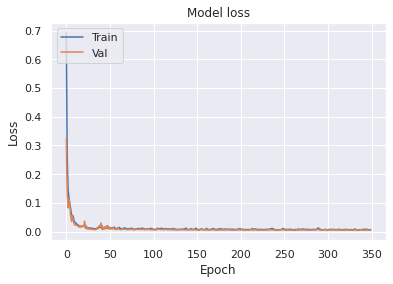

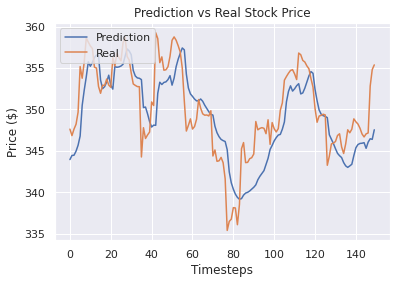

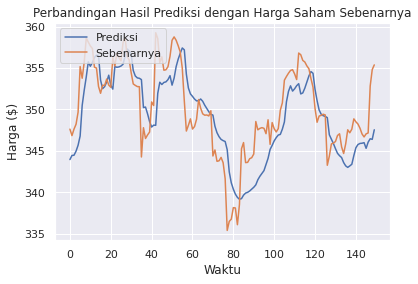

#Train Samples:  793 #Val Samples:  158
Val MAPE:  1.4293967704023172
Val Adjusted MAPE:  1.0364051110092898
Val Accuracy:  0.7692307692307693


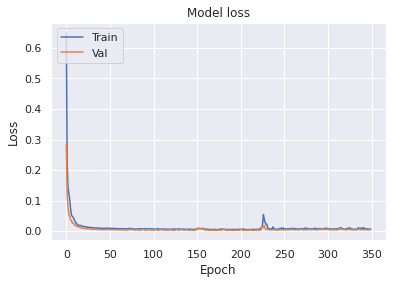

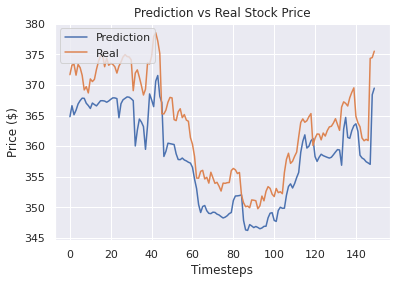

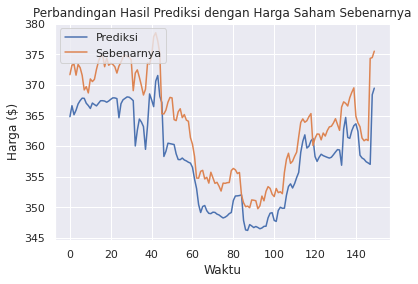

#Train Samples:  951 #Val Samples:  158
Val MAPE:  2.7370134022430532
Val Adjusted MAPE:  2.0108723609046812
Val Accuracy:  0.7342657342657343


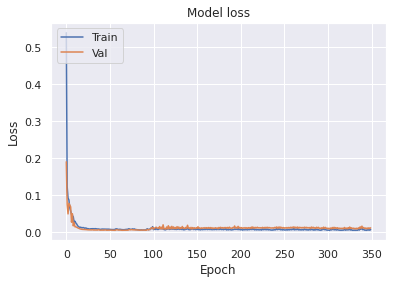

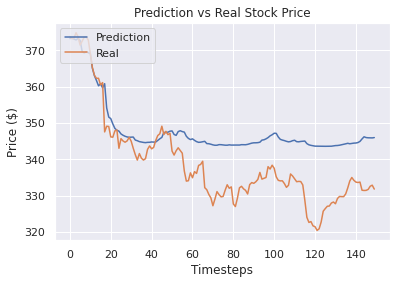

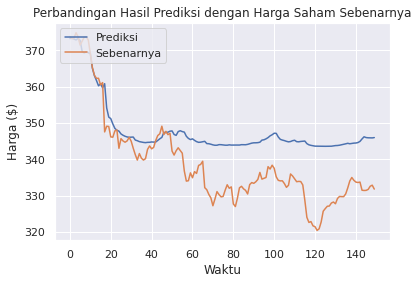

#Train Samples:  1109 #Val Samples:  158
Val MAPE:  0.9074451763494952
Val Adjusted MAPE:  0.6979294849923239
Val Accuracy:  0.8181818181818182


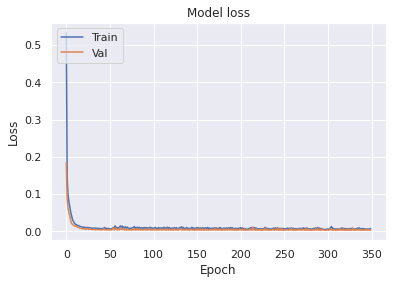

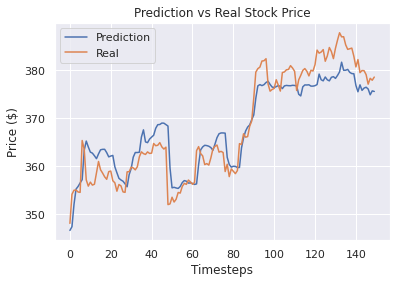

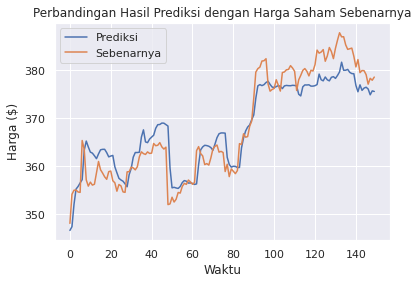

#Train Samples:  1267 #Val Samples:  158
Val MAPE:  1.303027271269678
Val Adjusted MAPE:  0.932220103087919
Val Accuracy:  0.8181818181818182


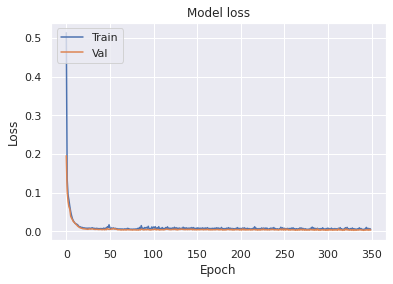

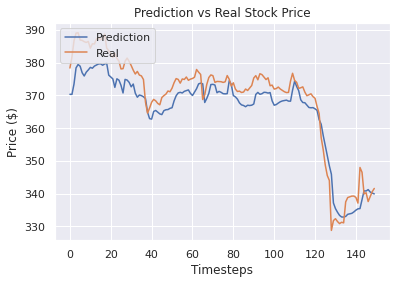

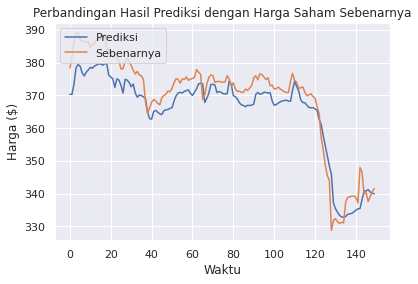

#Train Samples:  1425 #Val Samples:  158
Val MAPE:  1.5267182338202134
Val Adjusted MAPE:  1.1231586314939135
Val Accuracy:  0.7902097902097902


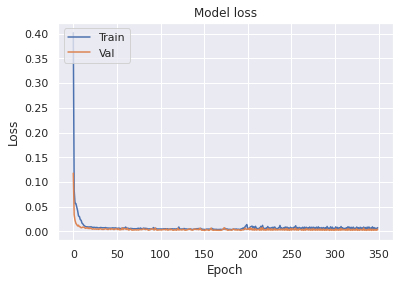

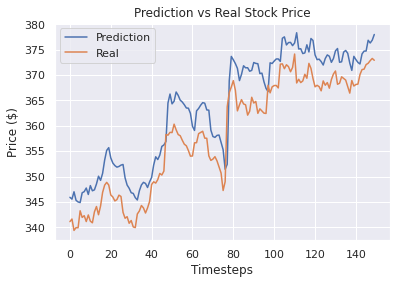

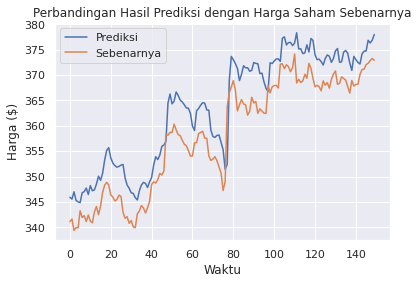

#Train Samples:  1583 #Val Samples:  158
Val MAPE:  0.7844195397881389
Val Adjusted MAPE:  0.5503814953273958
Val Accuracy:  0.7692307692307693


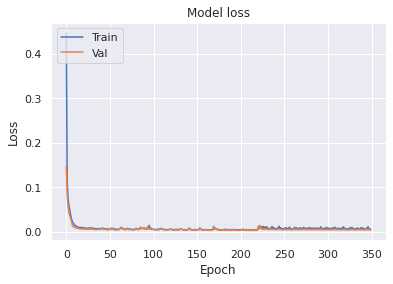

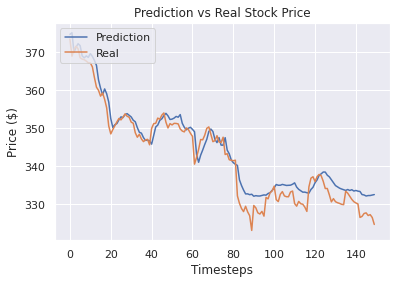

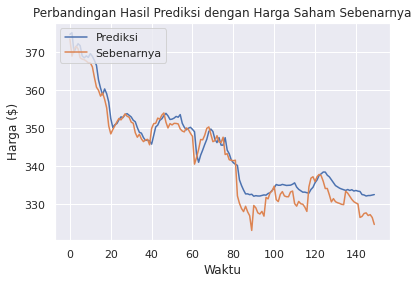

10-Fold Accuracy Test Avg Score: 0.7475524475524475, Std Score: 0.051998073972087576
10-Fold MAPE Test Avg Score: 1.5936795459708848, Std Score: 0.7210983167953218
10-Fold Adjusted MAPE Test Avg Score: 1.1879655539098306, Std Score: 0.5609127489933978
Epochs: 350
LSTM Nodes 1: 256
LSTM Nodes 2: 128
Input Dropout Rate: 0
Hidden Dropout Rate: 0.2
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f187c03c748>



In [10]:
cross_val(df,TIME_STEPS=7,BATCH_SIZE=25,n_fold=10,
          input_dropout=0,hidden_dropout=0.2,l2_regularizer=0.005,
          lstm_units_1=256,lstm_units_2=128,
          hidden_units_1=128,hidden_units_2=64,
          optimizer=optimizers.Adam(learning_rate=0.0005),
          epochs=350)